In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from matplotlib.colors import LogNorm, Normalize
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import constants
#sns.set_theme()
import re
from scipy import ndimage
import matplotlib as mpl
import utils

In [2]:
no_reflector = "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin"
best_restult = "felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin"
munkholm = "felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin"
ali = "felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin"
try:
    #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
    #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
    with open(ali , "rb") as f:

        data = f.read()
    
        
        
except IOError as e:
    print(e)

In [10]:
stri = "DONE"
done = False
data_arr = []
index = 0
data_bytes = data
while(not done):
    ls = re.search(stri.encode(), data_bytes).end()
    data_arr.append(data_bytes[:ls])
    data_bytes = data_bytes[ls+4:]
    print(len(data_bytes))
    if(len(data_bytes) == 0):
        done = True

606405008
605355808
604306560
603257300
602208052
601158780
600109496
599060204
598010792
596961452
595912112
594862796
593813536
592764268
591715060
590665816
589616676
588567444
587518248
586469040
585419832
584370636
583321452
582272208
581222976
580173696
579124476
578075244
577026012
575976804
574927608
573878388
572829180
571780020
570730824
569681664
568632480
567583332
566534172
565484976
564435732
563386476
562337256
561288024
560238828
559189608
558140376
557091168
556041984
554992776
553943580
552894372
551845188
550795968
549746748
548697588
547648380
546599172
545549964
544500732
543451548
542402364
541353224
540304048
539254932
538205816
537156676
536107416
535058156
534008872
532959564
531910400
530861248
529812016
528762676
527713408
526664248
525615040
524565808
523516600
522467440
521418304
520369120
519319984
518270812
517221652
516172536
515123412
514074320
513025148
511975952
510926768
509877524
508828244
507779060
506729972
505680812
504631652
503582456
502533344


# Functions

## Backgorund update

In [4]:
c = constants.c
sample_bandwidth  = 191.0153846e6
sample_frek = 2*sample_bandwidth # sample frekuenzy
frame_rate =50*10**(-3) # frame rate
sample_per_frame = 260*257 # sample pr frame
c_t = (1/sample_bandwidth )*256 # sample period
#fs_new = 1/sample_period_new # sample frekuenzy 

In [5]:
def simple_exp_smooth(d,extra_periods=1,alpha=0.4):  
  #d = np.array(d)  # Transform the input into a numpy array  
  cols = len(d)  # Historical period length  
  #d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
  f = np.zeros_like(d)  # Forecast array  
  f[0] = d[0]  # initialization of first forecast  
 
  # Create all the t+1 forecasts until end of historical period  
  for t in range(1,cols):  
    f[t] = alpha*d[t]+(1-alpha)*f[t-1]
  #print(f)  
  f[cols+1:] = f[t]  # Forecast for all extra periods  
  #df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f})
  return f,d

In [6]:
def background_update(frames, alpha=1/128, nr_of_ma=1,window=1):
    fft_length = 256
    MRDM =np.zeros((len(frames),fft_length,fft_length),dtype=np.complex_)
    
    for i,frame in enumerate(frames):
        length = int.from_bytes(
                 frame[4:8], byteorder="little", signed=False)
        
        data_RADC = frame[8:8+length]
        data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
        data_RADC = data_RADC.reshape(3,256,512)
        data_RADC_I_raw = data_RADC[:,:,::2]
        data_RADC_Q_raw = data_RADC[:,:,1::2]
        data_RADC_I = detrend(data_RADC_I_raw, axis=2)
        data_RADC_Q = detrend(data_RADC_Q_raw, axis=2)
        #window = signal.windows.chebwin(256, 100, sym=True)#signal.windows.hann(256)
        #data_RADC_I_mean = np.mean(data_RADC_I, axis=0)
        #data_RADC_Q_mean = np.mean(data_RADC_Q, axis=0)
        data_RADC_I_mean = data_RADC_I[0]
        data_RADC_Q_mean = data_RADC_Q[0]
        data_IF = window*data_RADC_I_mean[:,:] + window*1j*data_RADC_Q_mean[:,:]
       

        data_range_baseline =utils.fft_and_plot(data_IF, axis=1, fs=sample_frek,fft_size=fft_length,plot=False,shift =False)
       #data_range_baseline = utils.MIT_filter( data_range_baseline)
        for j in range(fft_length):
             data_range_baseline[:,j] = window*data_range_baseline[:,j]
        data_range_baseline = utils.MIT_filter( data_range_baseline)
        data_doppler_window_slow= utils.fft_and_plot(data_range_baseline, axis=0,fft_size=fft_length,shift =True)
     
        #MRDM[i]=cv2.GaussianBlur(np.abs(data_doppler_window_slow) ,(3, 3),sigmaX=1,sigmaY=1)
        MRDM[i] = data_doppler_window_slow

    #MIT
   
   
    data_diff = MRDM.copy()
    raw_frames = MRDM.copy()
    for i in range(nr_of_ma):
        MRDM,frames =simple_exp_smooth(data_diff,alpha =alpha)
        data_diff = np.abs(frames) -np.abs(MRDM)
        print("MA",i)
    #data_diff = np.abs(frames[-1]) -np.abs(MRDM[-2])
    utils.CFAR_2D(data_diff[-1].copy(),10, 15, 0.000001,plot=False, iso_axis=True)
    return MRDM,raw_frames,data_diff

In [7]:
def all_cfar(data_arr, nr_of_ma=0, alpha=1/256, mode="nearest",window=1 ,plot=False,saveFig=False,FileName="CFAR"):
    data_ma,raw_t,data_diff = background_update(data_arr,nr_of_ma=
        nr_of_ma, alpha=alpha,window = window)
    cfar_array= []
    SNR_array = []
    SNR_D_array = []
    length_data_diff = len(data_diff[:-1])
    for i,img in enumerate( data_diff[:-1]):
        cfar ,y,SNR,d= utils.CFAR_2D(img,10, 15, 0.000001,plot=False, iso_axis=True)
        cfar_array.append(cfar)
        cfar_array.append(cfar)
        SNR_array.append(SNR)
        SNR_D_array.append(y)
        print(np.round(i/length_data_diff*100,1))

    labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
    
    test = np.max(np.abs(cfar_array),axis=0)
    test[test < 1.1] =0
    test[test>1] =1
    plt.figure(figsize=(10,10))
    print(np.shape(test))
    rotated_img =np.abs(test) # We rotate the image so the x axis is the velocity
    cmap = mpl.colors.ListedColormap(['darkBlue','red'])
    bounds=[-0,1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(rotated_img,interpolation='nearest',cmap = cmap,norm=norm)
    plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
    #cbar  = plt.colorbar()
    #cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
    #cbar.ax.tick_params(labelsize=15) 
    plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
    plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
    #plt.title(labels["title"],fontdict = {'fontsize' : 30})
    plt.grid(False)
    if saveFig:
        plt.savefig(f"cfar_io/{FileName}.svg",format="svg")
    plt.show()
    return cfar_array,SNR_array,SNR_D_array

MA 0
MA 1
MA 2
0.0
0.2
0.3
0.5
0.7
0.9
1.0
1.2
1.4
1.6
1.7
1.9
2.1
2.2
2.4
2.6
2.8
2.9
3.1
3.3
3.5
3.6
3.8
4.0
4.2
4.3
4.5
4.7
4.8
5.0
5.2
5.4
5.5
5.7
5.9
6.1
6.2
6.4
6.6
6.7
6.9
7.1
7.3
7.4
7.6
7.8
8.0
8.1
8.3
8.5
8.7
8.8
9.0
9.2
9.3
9.5
9.7
9.9
10.0
10.2
10.4
10.6
10.7
10.9
11.1
11.2
11.4
11.6
11.8
11.9
12.1
12.3
12.5
12.6
12.8
13.0
13.1
13.3
13.5
13.7
13.8
14.0
14.2
14.4
14.5
14.7
14.9
15.1
15.2
15.4
15.6
15.7
15.9
16.1
16.3
16.4
16.6
16.8
17.0
17.1
17.3
17.5
17.6
17.8
18.0
18.2
18.3
18.5
18.7
18.9
19.0
19.2
19.4
19.6
19.7
19.9
20.1
20.2
20.4
20.6
20.8
20.9
21.1
21.3
21.5
21.6
21.8
22.0
22.1
22.3
22.5
22.7
22.8
23.0
23.2
23.4
23.5
23.7
23.9
24.0
24.2
24.4
24.6
24.7
24.9
25.1
25.3
25.4
25.6
25.8
26.0
26.1
26.3
26.5
26.6
26.8
27.0
27.2
27.3
27.5
27.7
27.9
28.0
28.2
28.4
28.5
28.7
28.9
29.1
29.2
29.4
29.6
29.8
29.9
30.1
30.3
30.4
30.6
30.8
31.0
31.1
31.3
31.5
31.7
31.8
32.0
32.2
32.4
32.5
32.7
32.9
33.0
33.2
33.4
33.6
33.7
33.9
34.1
34.3
34.4
34.6
34.8
34.9
35.1
35.3
35.5
35.6
35.8
36.

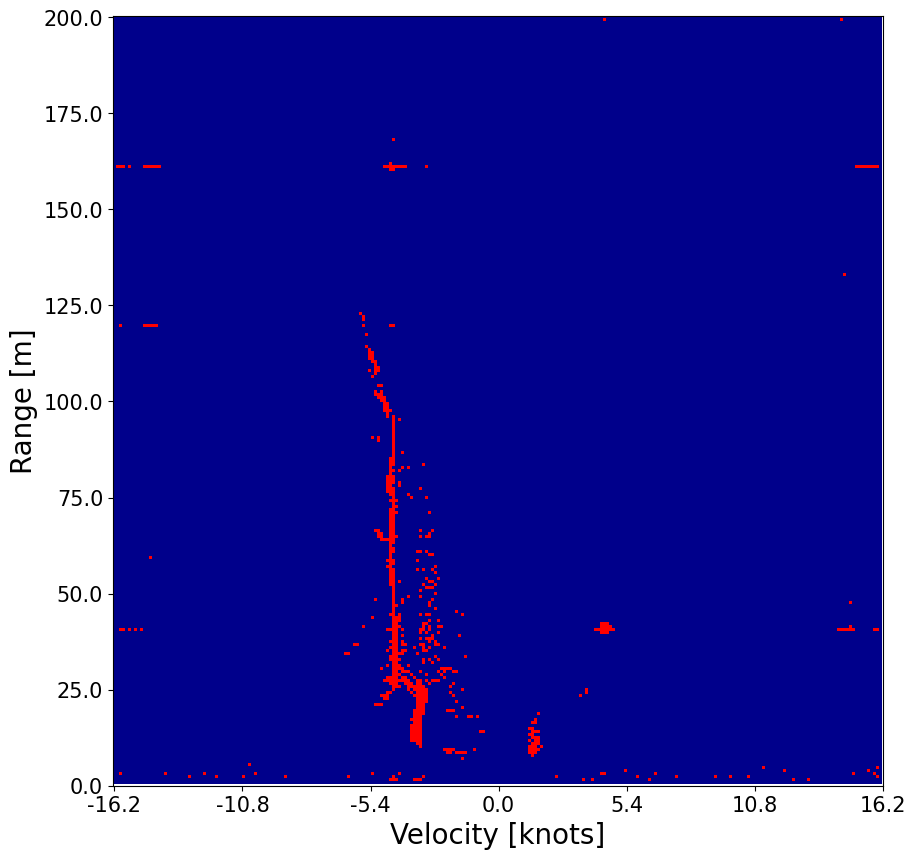

In [11]:
cfar_array,SNR_array,SNR_D_array= all_cfar(data_arr, nr_of_ma=3, alpha=1/256, mode="nearest",window=1 ,plot=False,saveFig=True,FileName="ali_ema_io")

0.0
0.2
0.3
0.5
0.7
0.9
1.0
1.2
1.4
1.6
1.7
1.9
2.1
2.2
2.4
2.6
2.8
2.9
3.1
3.3
3.5
3.6
3.8
4.0
4.2
4.3
4.5
4.7
4.8
5.0
5.2
5.4
5.5
5.7
5.9
6.1
6.2
6.4
6.6
6.7
6.9
7.1
7.3
7.4
7.6
7.8
8.0
8.1
8.3
8.5
8.7
8.8
9.0
9.2
9.3
9.5
9.7
9.9
10.0
10.2
10.4
10.6
10.7
10.9
11.1
11.2
11.4
11.6
11.8
11.9
12.1
12.3
12.5
12.6
12.8
13.0
13.1
13.3
13.5
13.7
13.8
14.0
14.2
14.4
14.5
14.7
14.9
15.1
15.2
15.4
15.6
15.7
15.9
16.1
16.3
16.4
16.6
16.8
17.0
17.1
17.3
17.5
17.6
17.8
18.0
18.2
18.3
18.5
18.7
18.9
19.0
19.2
19.4
19.6
19.7
19.9
20.1
20.2
20.4
20.6
20.8
20.9
21.1
21.3
21.5
21.6
21.8
22.0
22.1
22.3
22.5
22.7
22.8
23.0
23.2
23.4
23.5
23.7
23.9
24.0
24.2
24.4
24.6
24.7
24.9
25.1
25.3
25.4
25.6
25.8
26.0
26.1
26.3
26.5
26.6
26.8
27.0
27.2
27.3
27.5
27.7
27.9
28.0
28.2
28.4
28.5
28.7
28.9
29.1
29.2
29.4
29.6
29.8
29.9
30.1
30.3
30.4
30.6
30.8
31.0
31.1
31.3
31.5
31.7
31.8
32.0
32.2
32.4
32.5
32.7
32.9
33.0
33.2
33.4
33.6
33.7
33.9
34.1
34.3
34.4
34.6
34.8
34.9
35.1
35.3
35.5
35.6
35.8
36.0
36.2
36.3
36.

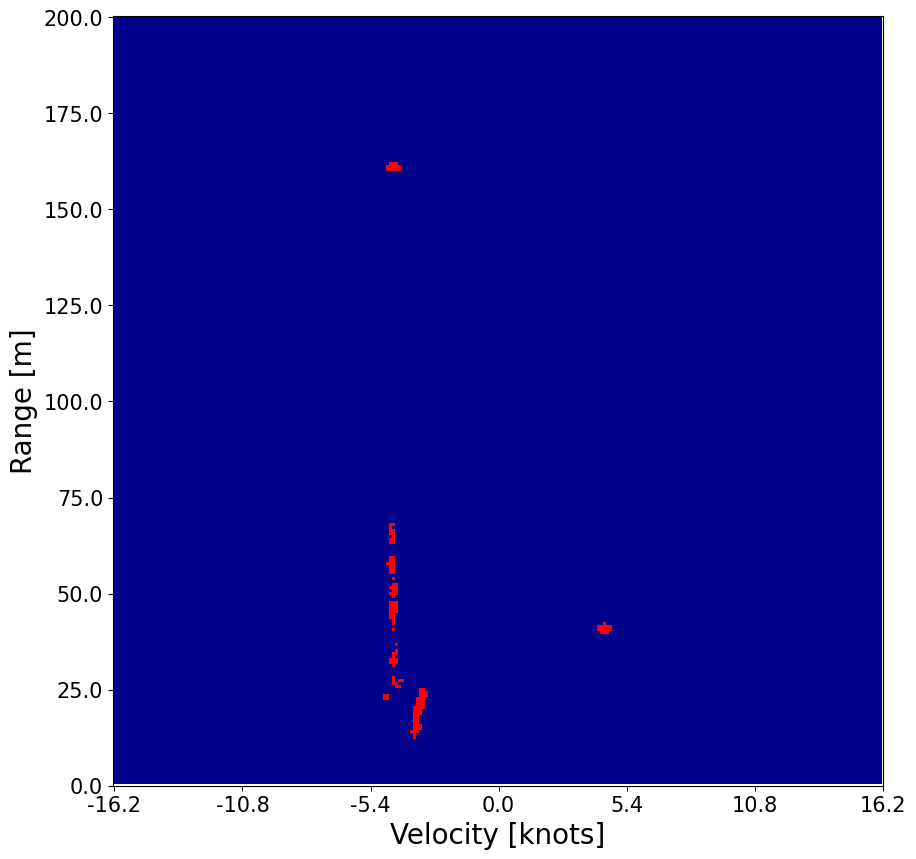

In [14]:
cfar_array,SNR_array,SNR_D_array= all_cfar(data_arr, nr_of_ma=0, alpha=1/256, mode="nearest",window=signal.windows.chebwin(256, 100, sym=True) ,plot=False,saveFig=True,FileName="ali_munk_io_100")